# Data munging

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import re

In [2]:
race_df = pd.read_csv("../scraping/fis_scrape/worldloppet_races.csv")

#how many racers
print(len(race_df))

#define index for get function
#print(race_df.race_description.str.split()[1])

new_race_df = race_df.copy()
new_race_df.head(5)

#break down formatting one at a time to troubleshoot any new errors

614292


,race_description,race_name,racer_nationality,racer_time
0,12.08.2017 48 km CT,Ushuaia Loppet Main,ARG,02:16:34
1,12.08.2017 48 km CT,Ushuaia Loppet Main,ARG,02:35:10
2,12.08.2017 48 km CT,Ushuaia Loppet Main,POL,02:48:40
3,12.08.2017 48 km CT,Ushuaia Loppet Main,ARG,02:49:54
4,12.08.2017 48 km CT,Ushuaia Loppet Main,ARG,02:51:14


In [3]:
#race date NB *very* long step
new_race_df['date'] = pd.to_datetime(race_df.race_description.str.split().str.get(0).str.replace(".", "-"))

In [4]:
new_race_df['year'] = new_race_df.date.dt.year

In [5]:
new_race_df['month'] = new_race_df.date.dt.month

In [6]:
new_race_df['week'] = new_race_df.date.dt.weekofyear

In [7]:
print(race_df.race_name.unique())

# first, setup a host country tag (good for the compare to racer_nationality rationale)
# so, idea being that if I can breakdown by host country... should be able to get most popular races(by country)

# then, define the splitting distance for short/long races. (optional, really)
# will have to condense the list of 173 unique race_names (fortunately plenty of redundancy
# should have to setup 20 ifelses like (if contains china == CHN or america == USA)

['Ushuaia Loppet Main' 'Kangaroo Hoppet Main' 'Merino Muster Main'
 'Vasaloppet China Main' 'Dolomitenlauf CL' 'Dolomitenlauf Main'
 'Marcialonga Main' 'König Ludwig Lauf FT' 'König Ludwig Lauf Main'
 'Sapporo Int. Ski Marathon Main' 'La Transjurassienne Classic'
 'La Transjurassienne Marathon' 'La Transjurassienne Main'
 'Tartu Maraton Open Track' 'Gatineau Loppet CL' 'Jizerská Padesatka Main'
 'Gatineau Loppet Main' 'Tartu Maraton Main' 'Finlandia-hiihto Main'
 'American Birkebeiner Birkie FT' 'American Birkebeiner Birkie CL'
 'Finlandia-hiihto 100' 'Finlandia-hiihto ' 'Vasaloppet Oppet Spar Sun'
 'Vasaloppet Oppet Spar Mon' 'Bieg Piastow Main'
 'Demino Ski Marathon Main' 'Vasaloppet Main' 'Engadin Skimarathon Main'
 'Birkebeinerrennet FredagsBirken CT/FT' 'Birkebeinerrennet Main'
 'Ushuaia Loppet Promo' 'Ushuaia Loppet Marchablanca'
 'Kangaroo Hoppet Australian Birkebeiner' 'Merino Muster Snow Rake'
 'Vasaloppet China Short' 'Dolomitenlauf Short CL'
 'Dolomitenlauf Lienz Lauf' 'Marc

In [8]:
# setup a function which generates a 'host country' based on 'race_name' string

def host_country_gen(r):
    if 'Ushuaia' in r:
        return "ARG"
    elif 'American' in r:
            return "USA"
    elif 'Kangaroo' in r:
            return "AUS"
    elif 'Bieg' in r:
            return "POL"
    elif 'Transjurassienne' in r:
            return "FRA"
    elif 'Dolomitenlauf' in r:
            return "AUT"
    elif 'Marcialonga' in r:
            return "ITA"
    elif 'Engadin' in r:
            return "SUI"
    elif 'Padesatka' in r:
            return "CZE"
    elif 'Ludwig' in r:
            return "GER"
    elif 'Tartu' in r:
            return "EST"
    elif 'Finland' in r:
            return "FIN"
    elif 'China' in r:
            return "CHN"
    elif 'Sapporo' in r:
            return "JPN"
    elif 'Gatineau' in r:
            return "CAN"
    elif 'Birkebeinerrennet' in r:
            return "NOR"
    elif 'Fossavatnsgangan' in r:
            return "ISL"
    elif 'Merino' in r:
            return "NZL"
    elif 'Demino' in r:
            return "RUS"
    elif 'Vasaloppet' in r:
            return "SWE"
    else:
        return "none"

In [9]:
new_race_df['host_country'] = race_df.race_name.apply(host_country_gen)
print(new_race_df.host_country.unique())
len(new_race_df.host_country.unique())
# all countries accounted for !!  
# confirm no misattributes but with vasaloppet last should be OK

['ARG' 'AUS' 'NZL' 'CHN' 'AUT' 'ITA' 'GER' 'JPN' 'FRA' 'EST' 'CAN' 'CZE'
 'FIN' 'USA' 'SWE' 'POL' 'RUS' 'SUI' 'NOR' 'ISL']


20

In [10]:
# setup quick numerical boolean to query tourist %'s
# 0 = racer is native; 1 = racer is a visitor (tourist)
new_race_df['tourist'] = np.where(new_race_df.racer_nationality != new_race_df.host_country, 1, 0)
#fastcheck
new_race_df.groupby('host_country').mean()['tourist'].sort_values(ascending = False)

host_country
AUT    0.800848
NZL    0.671164
ITA    0.661302
ISL    0.596610
GER    0.569041
CHN    0.495010
ARG    0.329457
SUI    0.286586
CAN    0.247219
POL    0.245444
FIN    0.237778
CZE    0.223501
AUS    0.211349
FRA    0.209550
EST    0.176132
SWE    0.119791
NOR    0.114620
RUS    0.086763
JPN    0.075348
USA    0.029520
Name: tourist, dtype: float64

In [11]:
#race distance
new_race_df['distance'] = pd.to_numeric(race_df.race_description.str.split().str.get(1).str.replace(',', '.'))

In [12]:
#race style
new_race_df['style'] = race_df.race_description.str.split().str.get(3)
new_race_df['style'].unique()

array(['CT', 'FT'], dtype=object)

In [13]:
#racer nationality
new_race_df['racer_nationality'] = new_race_df['racer_nationality'].str.upper()

In [14]:
#racer time 
new_race_df['racer_time'] = pd.to_timedelta(new_race_df.racer_time.str.extract('(\d+[:|.]\d{2}[:|.]\d{2})').str.replace(".", ":"))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [15]:
new_race_df['racer_pace'] = new_race_df['distance'] / (new_race_df['racer_time'] / dt.timedelta(hours=1))

In [16]:
### after evaluating racer_pace, I came to the realization that there are some "DNF" finish times
### therefore, I will split the df into two: race_finishers and race_dnf using null/notnull arguments

race_finishers = new_race_df[pd.notnull(new_race_df.racer_pace)].copy()

race_dnf = new_race_df[pd.isnull(new_race_df.racer_pace)].copy()

In [17]:
race_finishers.head()

,race_description,race_name,racer_nationality,racer_time,date,year,month,week,host_country,tourist,distance,style,racer_pace
0,12.08.2017 48 km CT,Ushuaia Loppet Main,ARG,02:16:34,2017-12-08,2017,12,49,ARG,0,48.0,CT,21.088601
1,12.08.2017 48 km CT,Ushuaia Loppet Main,ARG,02:35:10,2017-12-08,2017,12,49,ARG,0,48.0,CT,18.560687
2,12.08.2017 48 km CT,Ushuaia Loppet Main,POL,02:48:40,2017-12-08,2017,12,49,ARG,1,48.0,CT,17.075099
3,12.08.2017 48 km CT,Ushuaia Loppet Main,ARG,02:49:54,2017-12-08,2017,12,49,ARG,0,48.0,CT,16.951148
4,12.08.2017 48 km CT,Ushuaia Loppet Main,ARG,02:51:14,2017-12-08,2017,12,49,ARG,0,48.0,CT,16.819155


In [18]:
race_finishers.groupby(['host_country', "year"])['style'].count()

host_country  year
ARG           2014       92
              2015      201
              2016       55
              2017      168
AUS           2012      639
              2013      498
              2014      576
              2015      575
              2016      586
              2017      563
AUT           2013     1244
              2014     1688
              2015      988
              2016     1032
              2017      843
              2018     1039
CAN           2013     1019
              2014     1231
              2015     1031
              2016     1087
              2017     1192
              2018     1272
CHN           2015      323
              2016      295
              2017      415
              2018      470
CZE           2013     5319
              2015     5226
              2016     3400
              2017     5167
                      ...  
NZL           2017      148
POL           2013     3575
              2014     1488
              2015     3072
 

# Preliminary data visualization / EDA

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')

Text(0.5,1,'Median race pace by host country')

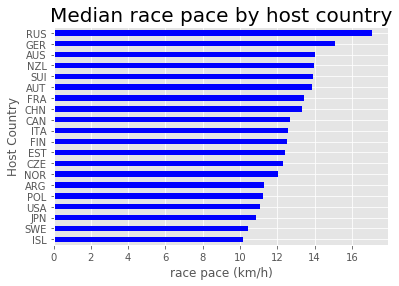

In [20]:
race_finishers.groupby('host_country')['racer_pace'].median().sort_values().plot(kind = 'barh', color='b')
plt.xlabel('race pace (km/h)')
plt.ylabel('Host Country')
plt.title('Median race pace by host country', fontsize=20)
# consider a split for long/short races? some division by distance

Text(0.5,1,'Median race pace by race')

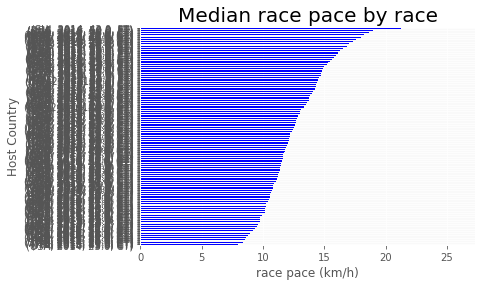

In [21]:
race_finishers.groupby(['host_country', 'year', 'distance', 'style'])['racer_pace'].median().sort_values().plot(kind = 'barh', color='b')
plt.xlabel('race pace (km/h)')
plt.ylabel('Host Country')
plt.title('Median race pace by race', fontsize=20)

In [22]:
race_finishers.groupby(['host_country', 'year', 'distance', 'style'])['racer_pace'].median().sort_values(ascending = False).tail(25)

host_country  year  distance  style
SWE           2018  30.0      CT       9.390896
              2015  30.0      CT       9.375814
FRA           2018  25.0      CT       9.368169
CAN           2015  27.0      CT       9.214144
FIN           2015  32.0      CT       9.146487
USA           2015  25.0      CT       9.056148
FIN           2016  32.0      CT       9.043806
USA           2014  23.0      FT       8.993646
ITA           2018  45.0      CT       8.906482
USA           2018  29.0      CT       8.905570
AUT           2014  20.0      CT       8.861644
NOR           2016  15.0      CT       8.809135
USA           2013  23.0      CT       8.683797
FIN           2013  32.0      CT       8.621787
              2017  32.0      CT       8.616305
ISL           2015  25.0      CT       8.548230
ITA           2014  45.0      CT       8.533052
FRA           2017  25.0      CT       8.511912
SWE           2014  30.0      CT       8.511309
FIN           2014  20.0      CT       8.503602
ARG 

In [23]:
len(race_finishers.groupby(['host_country', 'year', 'distance', 'style'])['racer_pace'].median())

314

Text(0.5,1,'Race pace distribution')

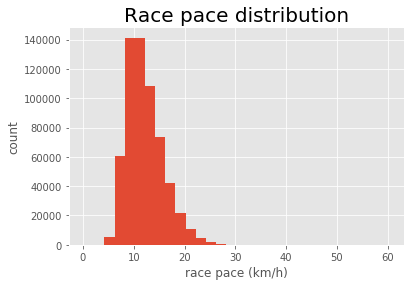

In [24]:
plt.hist((race_finishers.racer_pace), bins = 30)
plt.xlabel('race pace (km/h)')
plt.ylabel('count')
plt.title('Race pace distribution', fontsize=20)

(array([ 7., 56., 21., 27., 37.,  7.,  2.,  1., 12.,  2.]),
 array([ 10.,  19.,  28.,  37.,  46.,  55.,  64.,  73.,  82.,  91., 100.]),
 <a list of 10 Patch objects>)

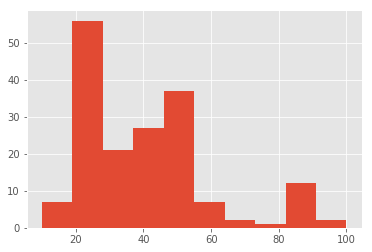

In [25]:
plt.hist(race_finishers.groupby('race_name')['distance'].mean(), bins = 10)
#this is a rough pass on the distance metric but looks like I need to apply normalization (box-cox?)

(array([255.,  19.,  12.,   6.,   2.,   7.,   3.,   3.,   1.,   0.,   0.,
          0.,   0.,   3.,   3.]),
 array([1.00000000e+01, 1.87186667e+03, 3.73373333e+03, 5.59560000e+03,
        7.45746667e+03, 9.31933333e+03, 1.11812000e+04, 1.30430667e+04,
        1.49049333e+04, 1.67668000e+04, 1.86286667e+04, 2.04905333e+04,
        2.23524000e+04, 2.42142667e+04, 2.60761333e+04, 2.79380000e+04]),
 <a list of 15 Patch objects>)

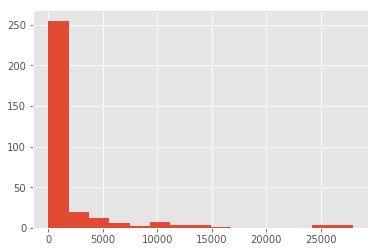

In [26]:
#number of racers at a given race
plt.hist(race_finishers.groupby(['host_country', 'year', 'distance', 'style'])['month'].count(), bins = 15)
#highly skewed ... log transform or something

In [27]:
compiled_table = race_finishers.groupby(['host_country', 'year', 'distance', 'style', 'month', 'week']).agg({'racer_pace' : ['median', 'max'], 'year' : ['count'], 'tourist' : ['mean']}).reset_index()
#df.reset_index(level='class', col_level=1, col_fill='species')
compiled_table

host_country  year distance style month week racer_pace              year  \
                                                     median        max  count   
0            ARG  2014     21.0    CT     8   33   9.578107  18.538499     57   
1            ARG  2014     21.0    FT    10   41   9.485992  12.007624     10   
2            ARG  2014     42.0    FT    10   41  11.536701  16.792537     25   
3            ARG  2015     21.0    CT     8   34   8.494879  16.328294     86   
4            ARG  2015     21.0    FT     9   37  16.085106  21.099637     21   
5            ARG  2015     42.0    FT     9   37  14.539919  22.516754     94   
6            ARG  2016     21.0    CT     8   33  12.009531  22.105263     55   
7            ARG  2017     21.0    FT     8   33  11.026838  19.879043     77   
8            ARG  2017     24.0    CT    12   49  11.288708  21.979140     30   
9            ARG  2017     48.0    CT    12   49  12.558140  21.088601     61   
10           AUS  2012     21.0    FT     8   34  13.742956  27.000000    283   
11           AUS  2012     42.0    FT     8   34  16.835577  30.361446    356   
12           AUS  2013     21.0    FT     8   34  10.898083  22.105263    227   
13           AUS  2013     42.0    FT     8   34  14.939235  28.789033    271   
14           AUS  2014     21.0    FT     8   34  12.053571  23.751178    271   
15           AUS  2014     42.0    FT     8   34  18.188380  31.480325    305   
16           AUS  2015     21.0    FT     8   34  14.288414  27.106490    273   
17           AUS  2015     42.0    FT     8   34  16.301009  27.641682    302   
18           AUS  2016     21.0    FT     8   34  10.809265  21.477273    289   
19           AUS  2016     42.0    FT     8   34  12.710155  22.225489    297   
20           AUS  2017     21.0    FT     8   34  12.181760  23.699060    277   
21           AUS  2017     42.0    FT     8   34  15.286624  25.872690    286   
22           AUT  2013     20.0    CT     1    3   9.965398  19.549280    133   
23           AUT  2013     20.0    FT     1    3  15.611475  21.778584     92   
24           AUT  2013     42.0    CT     1    3  11.786279  20.994168    658   
25           AUT  2013     42.0    FT     1    3  14.732534  22.716346    361   
26           AUT  2014     20.0    CT     1    3   8.861644  21.621622    226   
27           AUT  2014     20.0    FT     1    3  13.462977  22.318661    284   
28           AUT  2014     42.0    CT     1    3  11.538462  21.575342    773   
29           AUT  2014     42.0    FT     1    3  14.721059  23.272280    405   
..           ...   ...      ...   ...   ...  ...        ...        ...    ...   
301          SWE  2017     90.0    CT     2    8  10.480010  18.734821   8096   
302          SWE  2017     90.0    CT     2    9  10.706850  17.624980   4209   
303          SWE  2017     90.0    CT     5   18  11.830862  22.756005  13541   
304          SWE  2017     90.0    FT     3    9  11.795116  23.182599   1382   
305          SWE  2018     30.0    CT     2    8   9.390896  23.642732  12152   
306          SWE  2018     45.0    CT     2    9   9.465658  20.600203   3188   
307          SWE  2018     90.0    CT     2    8  10.480010  18.734821   8099   
308          SWE  2018     90.0    CT     2    9  10.706850  17.624980   4209   
309          SWE  2018     90.0    CT     4   14  11.160291  20.408163  13704   
310          USA  2013     23.0    CT     2    8   8.683797  18.878249   1033   
311          USA  2013     23.0    FT     2    8  11.436464  22.003720   1323   
312          USA  2013     50.0    FT     2    8  12.818687  23.201856   3954   
313          USA  2013     54.0    CT     2    8  10.224315  18.952910   1798   
314          USA  2014     23.0    CT     2    8   7.931034  18.602561   1009   
315          USA  2014     23.0    FT     2    8   8.993646  19.583728   1274   
316          USA  2014     50.0    FT     2    8  10.562761  22.307597   3736   
317          USA  2014     54.0    

In [28]:
compiled_table.columns
compiled_table.columns = compiled_table.columns.get_level_values(0)
print(compiled_table.columns)

compiled_table.columns.values[6] = 'median_pace'
compiled_table.columns.values[7] = 'max_pace'
compiled_table.columns.values[8] = 'n_ski'
print(compiled_table.columns)


Index(['host_country', 'year', 'distance', 'style', 'month', 'week',
       'racer_pace', 'racer_pace', 'year', 'tourist'],
      dtype='object')
Index(['host_country', 'year', 'distance', 'style', 'month', 'week',
       'median_pace', 'max_pace', 'n_ski', 'tourist'],
      dtype='object')


In [29]:
#backup as checkpoint
compiled_table.to_csv("worldloppet_munged.csv")

In [60]:
#split finishers into classic or skate 
classic = compiled_table[compiled_table['style']=='CT'].copy()
print("number of classic races: " + str(len(classic)))
skate = compiled_table[compiled_table['style']=='FT'].copy()
print("number of skate races: " + str(len(skate)))

number of classic races: 186
number of skate races: 145


# Prep for KNN classification

In [102]:
race_finishers = race_finishers[race_finishers['racer_pace']>1]

In [72]:
race_finishers.head(2)

,race_description,race_name,racer_nationality,racer_time,date,year,month,week,host_country,tourist,distance,style,racer_pace
0,12.08.2017 48 km CT,Ushuaia Loppet Main,ARG,02:16:34,2017-12-08,2017,12,49,ARG,0,48.0,CT,21.088601
1,12.08.2017 48 km CT,Ushuaia Loppet Main,ARG,02:35:10,2017-12-08,2017,12,49,ARG,0,48.0,CT,18.560687


In [103]:
#normalize data prior to KNN w/ box-cox transformation
from scipy import stats

bc_dist, maxlog, interval = stats.boxcox(race_finishers.distance, alpha=0.05)
print("dist_lambda = {:g}".format(maxlog))

bc_pace, maxlog, interval = stats.boxcox(race_finishers.racer_pace, alpha=0.05)
print("pace_lambda = {:g}".format(maxlog))

race_finishers['bc_dist'] = bc_dist
race_finishers['bc_pace'] = bc_pace

race_finishers.head(2)

dist_lambda = 0.37763
pace_lambda = -0.142847


,race_description,race_name,racer_nationality,racer_time,date,year,month,week,host_country,tourist,distance,style,racer_pace,bc_dist,bc_pace
0,12.08.2017 48 km CT,Ushuaia Loppet Main,ARG,02:16:34,2017-12-08,2017,12,49,ARG,0,48.0,CT,21.088601,8.775961,2.471600
1,12.08.2017 48 km CT,Ushuaia Loppet Main,ARG,02:35:10,2017-12-08,2017,12,49,ARG,0,48.0,CT,18.560687,8.775961,2.388236


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


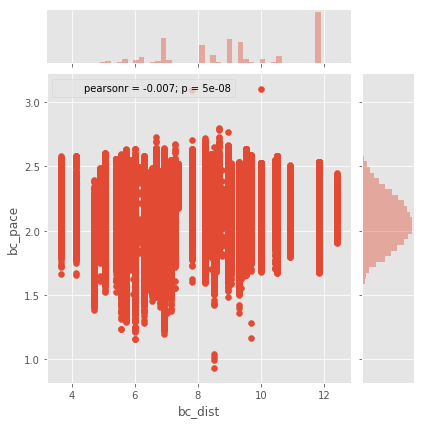

In [104]:
#check out the features 
import seaborn as sns
sns.jointplot(race_finishers['bc_dist'], race_finishers['bc_pace'])

In [105]:
# filter by ski-style as these are different races
import math
classic = race_finishers[race_finishers['style']=='CT'].copy()
print("number of classic racers: " + str(len(classic)))
print("sqrt(n) for K-neighbors, classic: " + str(math.sqrt(len(classic))))
skate = race_finishers[race_finishers['style']=='FT'].copy()
print("number of skate racers: " + str(len(skate)))
print("sqrt(n) for K-neighbors, skate: " + str(math.sqrt(len(skate))))

number of classic racers: 469296
sqrt(n) for K-neighbors, classic: 685.05182285722
number of skate racers: 143832
sqrt(n) for K-neighbors, skate: 379.2518951831355


###  KNN modeling for classic racers

In [76]:
import numpy as np
from sklearn.cross_validation import train_test_split

# create attribute matrix (bc_dist, bc_pace) and target (host_country) 
ski_data = np.array(classic.iloc[:,[13,14]]) 
host = np.array(classic.host_country) 

# setup train and test sets
ski_data_train, ski_data_test, host_train, host_test = train_test_split(ski_data, host, test_size=0.20, random_state=9)

The optimal number of neighbors is 101


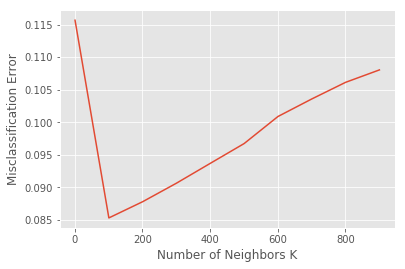

In [82]:
#now, test k iteratively starting with classic
#note, sqrt(n) printouts above

from sklearn.model_selection import cross_val_score

k_neighbors = [n for n in range(1,1000, 100) if n % 2 != 0] #start in 100s & avoid ties using odd neighbors

ct_cv_scores = []

# for i in k_neighbors:
#     knn = KNeighborsClassifier(n_neighbors=i)
#     scores = cross_val_score(knn, ski_data_train, host_train, cv=10, scoring='accuracy', n_jobs = -1)
#     ct_cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in ct_cv_scores]

# determining best k
optimal_k = k_neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(k_neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

### interpretation:
Given the sqrt(n) rule of thumb, I assumed that the optimal K neibhbors would be closer to 601. Turns out, the minimum error from this computational run is between 1 and 201. Let's repeat between 1 and 201 to generate a K to use.

In [87]:
k_neighbors_2 = [n for n in range(1,200, 10) if n % 2 != 0] #start in 100s & avoid ties using odd neighbors

ct_cv_scores_2 = []

# for i in k_neighbors_2:
#     knn = KNeighborsClassifier(n_neighbors=i)
#     scores = cross_val_score(knn, ski_data_train, host_train, cv=10, scoring='accuracy', n_jobs = -1)
#     ct_cv_scores_2.append(scores.mean())
    

The optimal number of neighbors is 701


The optimal number of neighbors is 71


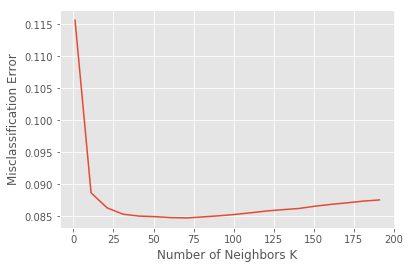

In [90]:
# changing to misclassification error
MSE_2 = [1 - x for x in ct_cv_scores_2]

# determining best k
optimal_k_2 = k_neighbors_2[MSE_2.index(min(MSE_2))]
print ("The optimal number of neighbors is %d" % optimal_k_2)

# plot misclassification error vs k
plt.plot(k_neighbors_2, MSE_2)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

###  KNN modeling for skate racers

In [91]:
import numpy as np
from sklearn.cross_validation import train_test_split

# create attribute matrix (bc_dist, bc_pace) and target (host_country) 
skate_ski_data = np.array(skate.iloc[:,[13,14]]) 
skate_host = np.array(skate.host_country) 

# setup train and test sets
ski_data_train2, ski_data_test2, host_train2, host_test2 = train_test_split(skate_ski_data, skate_host, test_size=0.20, random_state=9)

In [93]:
#repeat process as before

from sklearn.model_selection import cross_val_score

k_neighbors = [n for n in range(1,1000, 100) if n % 2 != 0] #start in 100s & avoid ties using odd neighbors

ft_cv_scores = []

for i in k_neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, ski_data_train2, host_train2, cv=10, scoring='accuracy', n_jobs = -1)
    ft_cv_scores.append(scores.mean())

The optimal number of neighbors is 101


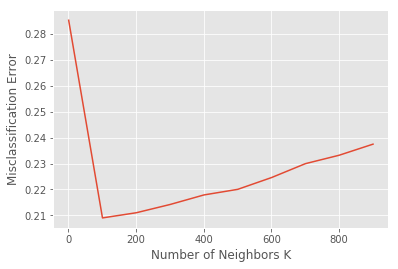

In [94]:
# changing to misclassification error
MSE3 = [1 - x for x in ft_cv_scores]

# determining best k
optimal_k = k_neighbors[MSE3.index(min(MSE3))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(k_neighbors, MSE3)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [95]:
k_neighbors_2 = [n for n in range(1,200, 10) if n % 2 != 0] #start in 100s & avoid ties using odd neighbors

ft_cv_scores_2 = []

for i in k_neighbors_2:
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, ski_data_train2, host_train2, cv=10, scoring='accuracy', n_jobs = -1)
    ft_cv_scores_2.append(scores.mean())

The optimal number of neighbors is 51


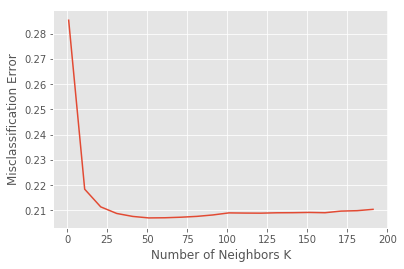

In [96]:
# changing to misclassification error
MSE_4 = [1 - x for x in ft_cv_scores_2]

# determining best k
optimal_k_2 = k_neighbors_2[MSE_4.index(min(MSE_4))]
print ("The optimal number of neighbors is %d" % optimal_k_2)

# plot misclassification error vs k
plt.plot(k_neighbors_2, MSE_4)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

# Final thoughts

These curves are remarkably similar in their shapes. I will use K = 61 as the change in misclassification error between 51 and 71 for both these curves is negligible. With this knowledge, I will loadup an R-shiny app that will do the following:
- Ask for ski style (CT/FT - as a filtering step)
- Ask for racing distance (input)
- Ask for racing pace (input)

Then, R will conduct a KNN classification on the selected dataset and return the most-similar host country to the individual's race profile.

Stretch goals include:
- Fancy output (scrape images of flags/logos & social media links)
- Month filtering (beta!)

In [109]:
#finalized output for model
model_ski_df = race_finishers.iloc[:,[11,8,13,14,6]]
print(model_ski_df.head(5))
model_ski_df.to_csv("model_ski_df.csv")

  style host_country   bc_dist   bc_pace  month
0    CT          ARG  8.775961  2.471600     12
1    CT          ARG  8.775961  2.388236     12
2    CT          ARG  8.775961  2.332943     12
3    CT          ARG  8.775961  2.328083     12
4    CT          ARG  8.775961  2.322862     12
